<a href="https://colab.research.google.com/github/menguri/Delivery_Traffic_Volume_Expecting/blob/main/%ED%83%9D%EB%B0%B0%EC%9A%B4%EC%86%A1%EB%9F%89_%EC%98%88%EC%B8%A1_(105_227).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **택배 운송량 예측**

1. **데이터/라이브러리 불러오기**
2. **EDA**
3. **모델 생성**
4. **학습**
5. **결과 도출 및 시각화**
6. **결과파일 생성**

# **1. 데이터/ 라이브러리 불러오기**

In [ ]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from google.colab import drive
drive.mount('/content/drive') 

# 지수 표현 없애기
pd.options.display.float_format = '{:.5f}'.format

Mounted at /content/drive


In [ ]:
# 폰트 지정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
# 데이터 불러오기

test = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/sample_submission.csv')
building_file = pd.read_excel('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/법정동.xlsx')                # 추가파일 1 (법정동)
building_file.to_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/법정동.csv')

In [ ]:
# 데이터 확인

train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000000000000.00000,5011000000000000.00000,패션의류,상의,3
1,1,1135000000000000.00000,5011000000000000.00000,생활/건강,반려동물,3
2,2,1135000000000000.00000,5011000000000000.00000,패션의류,기타패션의류,9
3,3,1154500000000000.00000,5011000000000000.00000,식품,농산물,10
4,4,1165000000000000.00000,5011000000000000.00000,식품,가공식품,3


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          32000 non-null  int64  
 1   SEND_SPG_INNB  32000 non-null  float64
 2   REC_SPG_INNB   32000 non-null  float64
 3   DL_GD_LCLS_NM  32000 non-null  object 
 4   DL_GD_MCLS_NM  32000 non-null  object 
 5   INVC_CONT      32000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ MB


In [ ]:
# 데이터 확인 2

test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000000000000.00000,1165000000000000.00000,식품,농산물
1,32001,5013000000000000.00000,1154500000000000.00000,식품,농산물
2,32002,5013000000000000.00000,4139000000000000.00000,식품,농산물
3,32003,5013000000000000.00000,4221000000000000.00000,식품,농산물
4,32004,5013000000000000.00000,2726000000000000.00000,식품,농산물


In [ ]:
# 추가 데이터 확인

building_file.head()

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,NaN,19880423,nan
1,1111000000,서울특별시,종로구,NaN,NaN,19880423,nan
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,nan
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,nan
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,nan


In [ ]:
# 제출파일 확인

submission.head()

,index,INVC_CONT
0,32000,0
1,32001,0
2,32002,0
3,32003,0
4,32004,0


FIRST STEP 결과 : 데이터는 운송의 고유번호와 카테고리(대,소), 운송량으로 구성되어 있다. 카테고리 만으로 운송량을 예측하거나, 혹은 고유번호에서 숨겨진 의미를 찾아야 할 것으로 보인다. 

# **1.5 데이터 전처리**

In [ ]:
# train과 test의 고유번호 정보를 str로 변환
train[['SEND_SPG_INNB', 'REC_SPG_INNB']] = train[['SEND_SPG_INNB', 'REC_SPG_INNB']].astype(str)
test[['SEND_SPG_INNB', 'REC_SPG_INNB']] = test[['SEND_SPG_INNB', 'REC_SPG_INNB']].astype(str)


# 추가 데이터는 총 10자리이기에 train, test 고유번호도 잘라줘야 함.
train['SEND_SPG_INNB'] = train['SEND_SPG_INNB'].str[:10]
train['REC_SPG_INNB'] = train['REC_SPG_INNB'].str[:10]
test['SEND_SPG_INNB'] = test['SEND_SPG_INNB'].str[:10]
test['REC_SPG_INNB'] = test['REC_SPG_INNB'].str[:10]

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          32000 non-null  int64 
 1   SEND_SPG_INNB  32000 non-null  object
 2   REC_SPG_INNB   32000 non-null  object
 3   DL_GD_LCLS_NM  32000 non-null  object
 4   DL_GD_MCLS_NM  32000 non-null  object
 5   INVC_CONT      32000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.5+ MB


In [ ]:
# 추가 데이터를 train, test 데이터와 합칠 수 있도록 가공.

building_file = building_file[['법정동코드', '시도명', '시군구명']].copy()
building_file['법정동코드'] = building_file['법정동코드'].astype(str)
building_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20565 entries, 0 to 20564
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   법정동코드   20565 non-null  object
 1   시도명     20565 non-null  object
 2   시군구명    20395 non-null  object
dtypes: object(3)
memory usage: 482.1+ KB


In [ ]:
# train, test 데이터의 법정동 코드를 대조시켜 지역 정보 추가.

train = pd.merge(train, building_file, how='left', left_on='SEND_SPG_INNB', right_on='법정동코드')
train['송하인_시도명'] = train['시도명']
train['송하인_시군구명'] = train['시군구명']
train = train.drop(['시도명','시군구명','법정동코드'], axis=1)

train = pd.merge(train, building_file, how='left', left_on='REC_SPG_INNB', right_on='법정동코드')
train['송수인_시도명'] = train['시도명']
train['송수인_시군구명'] = train['시군구명']
train = train.drop(['시도명','시군구명','법정동코드'], axis=1)

print('----------------------------')

test.info()
test = pd.merge(test, building_file, how='left', left_on='SEND_SPG_INNB', right_on='법정동코드')
test['송하인_시도명'] = test['시도명']
test['송하인_시군구명'] = test['시군구명']
test = test.drop(['시도명','시군구명','법정동코드'], axis=1)

test = pd.merge(test, building_file, how='left', left_on='REC_SPG_INNB', right_on='법정동코드')
test['송수인_시도명'] = test['시도명']
test['송수인_시군구명'] = test['시군구명']
test = test.drop(['시도명','시군구명','법정동코드'], axis=1)

----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4640 non-null   int64 
 1   SEND_SPG_INNB  4640 non-null   object
 2   REC_SPG_INNB   4640 non-null   object
 3   DL_GD_LCLS_NM  4640 non-null   object
 4   DL_GD_MCLS_NM  4640 non-null   object
dtypes: int64(1), object(4)
memory usage: 181.4+ KB


In [ ]:
print(train)
print(test.info())

       index SEND_SPG_INNB REC_SPG_INNB  ... 송하인_시군구명  송수인_시도명  송수인_시군구명
0          0    1129000000   5011000000  ...      성북구  제주특별자치도       제주시
1          1    1135000000   5011000000  ...      노원구  제주특별자치도       제주시
2          2    1135000000   5011000000  ...      노원구  제주특별자치도       제주시
3          3    1154500000   5011000000  ...      금천구  제주특별자치도       제주시
4          4    1165000000   5011000000  ...      서초구  제주특별자치도       제주시
...      ...           ...          ...  ...      ...      ...       ...
31995  31995    5011000000   2635000000  ...      제주시    부산광역시      해운대구
31996  31996    5011000000   1168000000  ...      제주시    서울특별시       강남구
31997  31997    5011000000   4119700000  ...      제주시      NaN       NaN
31998  31998    5011000000   1132000000  ...      제주시    서울특별시       도봉구
31999  31999    5011000000   4719000000  ...      제주시     경상북도       구미시

[32000 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4640 entries, 0 to 4639
Data columns (total 9 c

In [ ]:
# train의 고유번호가 test에 없는 경우가 존재한다. 이 경우, train의 데이터 일부를 날려야 한다.
# 송하인
train_send_list = list(set(train['SEND_SPG_INNB'].tolist()))
test_send_list = list(set(test['SEND_SPG_INNB'].tolist()))
# 송수인
train_rec_list = list(set(train['REC_SPG_INNB'].tolist()))
test_rec_list = list(set(test['REC_SPG_INNB'].tolist()))
# test에 있는 고유번호만 train에 남기기
send_item = [item for item in train_send_list if item in test_send_list]
rec_item = [item for item in train_rec_list if item in test_rec_list]
train_t = train['SEND_SPG_INNB'].isin(send_item)

In [ ]:
# test에 있는 고유번호만 train에 남기기
send_item = [item for item in train_send_list if item in test_send_list]
rec_item = [item for item in train_rec_list if item in test_rec_list]
train = train[train['SEND_SPG_INNB'].isin(send_item)]
train = train[train['REC_SPG_INNB'].isin(rec_item)]

In [ ]:
#['송하인_시군구명_거제시', '송하인_시군구명_양양군', '송하인_시군구명_울진군']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31547 entries, 0 to 31999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          31547 non-null  int64 
 1   SEND_SPG_INNB  31547 non-null  object
 2   REC_SPG_INNB   31547 non-null  object
 3   DL_GD_LCLS_NM  31547 non-null  object
 4   DL_GD_MCLS_NM  31547 non-null  object
 5   INVC_CONT      31547 non-null  int64 
 6   송하인_시도명        31415 non-null  object
 7   송하인_시군구명       31411 non-null  object
 8   송수인_시도명        30946 non-null  object
 9   송수인_시군구명       30763 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


지역, 카테고리만으로 일단 예측 실행.
그리고 결측치 어떻게 처리할 것인지 방안을 생각해야 함.
지역을 합칠 것인지, 그냥 지역구와 큰 지역을 나눠서 변수로 집어넣을 것인지도 생각. 

# **2. EDA**

A. 데이터 규모, 내용 파악

In [ ]:
# trian: 32000개, test: 4640개 / 결측치 없음

print(train.info())
print('----------------------------------------')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31547 entries, 0 to 31999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          31547 non-null  int64 
 1   SEND_SPG_INNB  31547 non-null  object
 2   REC_SPG_INNB   31547 non-null  object
 3   DL_GD_LCLS_NM  31547 non-null  object
 4   DL_GD_MCLS_NM  31547 non-null  object
 5   INVC_CONT      31547 non-null  int64 
 6   송하인_시도명        31415 non-null  object
 7   송하인_시군구명       31411 non-null  object
 8   송수인_시도명        30946 non-null  object
 9   송수인_시군구명       30763 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4640 entries, 0 to 4639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4640 non-null   int64 
 1   SEND_SPG_INNB  4640 non-null   object
 

B. 지역 분포& 운송량 상관관계 파악

In [ ]:
# train의 지역 정보 확인 
for i in ['송하인_시도명', '송수인_시도명']:                         #'송하인_시군구명',  '송하인_시군구명'
  distribution = train[i].value_counts() 
  print(distribution)
  print('--------------------------')

region_list = ['경기도', '제주특별자치도', '서울특별시', '부산광역시', '경상남도', '인천광역시', '충청남도', '경상북도',
               '전라북도', '대구광역시', '전라남도', '강원도', '대전광역시', '충청북도', '광주광역시', '울산광역시', '세종특별자치시']

# 제주 -> 제주 밖으로 보내는 경우가 훨씬 더 많다. 

제주특별자치도    25302
경기도         3805
서울특별시        822
대전광역시        227
대구광역시        168
부산광역시        154
충청남도         150
충청북도         144
경상북도         134
전라북도         124
인천광역시        109
강원도           96
경상남도          77
전라남도          53
광주광역시         46
세종특별자치시        4
Name: 송하인_시도명, dtype: int64
--------------------------
경기도        6704
제주특별자치도    6422
서울특별시      4984
부산광역시      1548
경상남도       1397
인천광역시      1267
충청남도       1182
경상북도       1136
전라북도        927
대구광역시       911
전라남도        885
강원도         860
대전광역시       682
충청북도        678
광주광역시       636
울산광역시       544
세종특별자치시     183
Name: 송수인_시도명, dtype: int64
--------------------------


In [ ]:
# 가공식품, 건강용품, 기타패션의류, 농산물, 축산 -> 지역별 평균 + 표준편차 확인하고, 차이가 없으면 사실상 지역 정보는 무의미한 것으로. 
region_df = {'지역' : [], '가공식품':[], '건강용품':[], '기타패션의류':[], '농산물':[], '축산':[]}
for region in  region_list:
    food_mean = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '가공식품')].mean()
    food_std = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '가공식품')].std()
    health_mean = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '건강용품')].mean()
    health_std = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '건강용품')].std()
    fashion_mean = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '기타패션의류')].mean()
    fashion_std = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '기타패션의류')].std()
    vege_mean = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '농산물')].mean()
    vege_std = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '농산물')].std()
    cow_mean = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '축산')].mean()
    cow_std = train['INVC_CONT'][(train['SEND_SPG_INNB'] == region) & (train['DL_GD_MCLS_NM'] == '축산')].std()
    
    region_df['지역']= region
    region_df['가공식품']= food_mean
    region_df['건강용품']= health_mean
    region_df['기타패션의류']= fashion_mean
    region_df['농산물']= vege_mean
    region_df['축산']= cow_mean


region_df

{'가공식품': nan,
 '건강용품': nan,
 '기타패션의류': nan,
 '농산물': nan,
 '지역': '세종특별자치시',
 '축산': nan}

C. 카테고리 분포& 운송량 상관관계 파악

In [ ]:
# 카테고리 종류& 분포 파악

print('대 카테고리')
print(train['DL_GD_LCLS_NM'].value_counts())
print('------------------------------------------')
for i in ['식품', '생활/건강', '여행/문화', '패션의류', '디지털/가전', '화장품/미용']:
  print(train['DL_GD_MCLS_NM'][train['DL_GD_LCLS_NM'] == i].value_counts())
  print('------------------------------------------')

대 카테고리
식품        27396
생활/건강      1979
여행/문화      1170
패션의류        546
디지털/가전      232
화장품/미용      224
Name: DL_GD_LCLS_NM, dtype: int64
------------------------------------------
농산물          22044
음료            1107
수산             907
가공식품           874
기타식품           712
건강식품           631
축산             403
냉동/간편조리식품      399
과자             319
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
음반         635
반려동물       353
생활용품       336
주방용품       310
문구/사무용품    176
건강용품       169
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
문화컨텐츠    1170
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
상의        313
기타패션의류    233
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
기타디지털/가전    232
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
스킨케어    224
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------


In [ ]:
print('대 카테고리')
print(test['DL_GD_LCLS_NM'].value_counts())
print('------------------------------------------')
for i in ['식품', '생활/건강', '여행/문화', '패션의류', '디지털/가전', '화장품/미용']:
  print(test['DL_GD_MCLS_NM'][test['DL_GD_LCLS_NM'] == i].value_counts())
  print('------------------------------------------')

대 카테고리
식품        4047
생활/건강      277
여행/문화      171
패션의류        82
디지털/가전      34
화장품/미용      29
Name: DL_GD_LCLS_NM, dtype: int64
------------------------------------------
농산물          3239
음료            167
수산            144
가공식품          134
기타식품          107
건강식품           88
축산             61
냉동/간편조리식품      55
과자             52
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
음반         85
생활용품       54
주방용품       47
반려동물       36
문구/사무용품    28
건강용품       27
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
문화컨텐츠    171
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
상의        47
기타패션의류    35
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
기타디지털/가전    34
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------
스킨케어    29
Name: DL_GD_MCLS_NM, dtype: int64
------------------------------------------


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

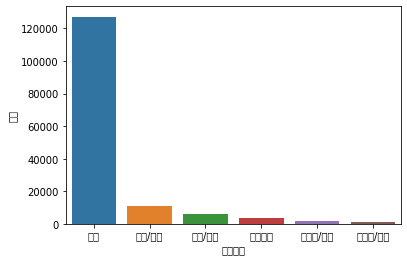

In [ ]:
# 대_카테고리와 운송량 / 운송량 합계는 식품, 생활&건강 파트에서 가장 많이 나왔다. 다만, 평균 1회 운송량은 패션의류, 디지털&가전에서 높게 나타났다. 

dict = {'카테고리': [], '합계': [], '평균': [], '표준편차': []}
for i in ['식품', '생활/건강', '여행/문화', '패션의류', '디지털/가전', '화장품/미용']:
  sum = train['INVC_CONT'][train['DL_GD_LCLS_NM'] == i].sum(axis=0, skipna=False)
  average = train['INVC_CONT'][train['DL_GD_LCLS_NM'] == i].mean(axis=0, skipna=False)
  std = train['INVC_CONT'][train['DL_GD_LCLS_NM'] == i].std()
  dict['카테고리'].append(i)
  dict['합계'].append(sum)
  dict['평균'].append(average)
  dict['표준편차'].append(std)

big_cate = pd.DataFrame(dict)
big_cate

In [ ]:
# 소_카테고리와 운송량 / 역시나 농산물, 음료 파트에서 가장 많이 나왔다. 하지만 평균 운송량은 기타패션의류/건강용품/축산에서 가장 많이 나온 것으로 집계된다. 

dict = {'카테고리': [], '합계': [], '평균': [], '표준편차': []}
for i in ['농산물','음료','수산','가공식품','기타식품','건강식품','축산','냉동/간편조리식품', 
          '과자','음반', '반려동물','생활용품','주방용품','문구/사무용품','건강용품','문화컨텐츠',
          '상의','기타패션의류','기타디지털/가전', '스킨케어']:
  sum = train['INVC_CONT'][train['DL_GD_MCLS_NM'] == i].sum(axis=0, skipna=False)
  average = train['INVC_CONT'][train['DL_GD_MCLS_NM'] == i].mean(axis=0, skipna=False)
  std = train['INVC_CONT'][train['DL_GD_MCLS_NM'] == i].std()
  dict['카테고리'].append(i)
  dict['합계'].append(sum)
  dict['평균'].append(average)
  dict['표준편차'].append(std)

small_cate = pd.DataFrame(dict)
small_cate

,카테고리,합계,평균,표준편차
0,농산물,94647,4.29355,3.70099
1,음료,6393,5.77507,7.18227
2,수산,5151,5.67916,5.79560
3,가공식품,5891,6.74027,11.07540
4,기타식품,4412,6.19663,7.39355
5,건강식품,3621,5.73851,7.44438
6,축산,3351,8.31514,10.87182
7,냉동/간편조리식품,1983,4.96992,6.36488
8,과자,1716,5.37931,5.84848
9,음반,2574,4.05354,2.91525


# **2.5 추가 데이터 전처리**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31547 entries, 0 to 31999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          31547 non-null  int64 
 1   SEND_SPG_INNB  31547 non-null  object
 2   REC_SPG_INNB   31547 non-null  object
 3   DL_GD_LCLS_NM  31547 non-null  object
 4   DL_GD_MCLS_NM  31547 non-null  object
 5   INVC_CONT      31547 non-null  int64 
 6   송하인_시도명        31415 non-null  object
 7   송하인_시군구명       31411 non-null  object
 8   송수인_시도명        30946 non-null  object
 9   송수인_시군구명       30763 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


In [ ]:
# 지역과 물품 카테고리만 변수로 사용할 것이므로, 나머지 칼럼은 제거.
target = train['INVC_CONT']
df_train = train.drop(['index'], axis=1)
df_test = test.drop(['index'], axis=1)

In [ ]:
# 고유번호를 예측에 사용할 것이기에 object -> float
df_train[['SEND_SPG_INNB', 'REC_SPG_INNB']] = df_train[['SEND_SPG_INNB', 'REC_SPG_INNB']].astype(int)
df_test[['SEND_SPG_INNB', 'REC_SPG_INNB']] = df_test[['SEND_SPG_INNB', 'REC_SPG_INNB']].astype(int)

In [ ]:
# one-hot encoding
df_train = pd.get_dummies(df_train, dummy_na=True)
df_test = pd.get_dummies(df_test, dummy_na=True)

In [ ]:
# 상관관계 있는 컬럼만 남기기
t_corr = df_train.corr()
cor_fe = t_corr.index[abs(t_corr['INVC_CONT']) >= 0.05]
cor_fe

Index(['SEND_SPG_INNB', 'REC_SPG_INNB', 'INVC_CONT', 'DL_GD_MCLS_NM_가공식품',
       'DL_GD_MCLS_NM_건강용품', 'DL_GD_MCLS_NM_기타패션의류', 'DL_GD_MCLS_NM_농산물',
       'DL_GD_MCLS_NM_축산', '송하인_시도명_경기도', '송하인_시도명_제주특별자치도',
       '송하인_시군구명_안양시 동안구', '송하인_시군구명_영양군', '송하인_시군구명_영주시', '송수인_시도명_제주특별자치도',
       '송수인_시군구명_제주시'],
      dtype='object')

In [ ]:
# 지역과 물품 카테고리만 변수로 사용할 것이므로, 나머지 칼럼은 제거.
target = train['INVC_CONT']
df_train = df_train[cor_fe]
df_train = df_train.drop(['INVC_CONT'], axis=1)
df_test = df_test[['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM_가공식품',
                  'DL_GD_MCLS_NM_건강용품', 'DL_GD_MCLS_NM_기타패션의류', 'DL_GD_MCLS_NM_농산물',
                  'DL_GD_MCLS_NM_축산', '송하인_시도명_경기도', '송하인_시도명_제주특별자치도',
                  '송하인_시군구명_안양시 동안구', '송하인_시군구명_영양군', '송하인_시군구명_영주시', '송수인_시도명_제주특별자치도', '송수인_시군구명_제주시']]

In [ ]:
df_train.head()

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_축산,송하인_시도명_경기도,송하인_시도명_제주특별자치도,송하인_시군구명_안양시 동안구,송하인_시군구명_영양군,송하인_시군구명_영주시,송수인_시도명_제주특별자치도,송수인_시군구명_제주시
0,1129000000,5011000000,0,0,0,0,0,0,0,0,0,0,1,1
1,1135000000,5011000000,0,0,0,0,0,0,0,0,0,0,1,1
2,1135000000,5011000000,0,0,1,0,0,0,0,0,0,0,1,1
3,1154500000,5011000000,0,0,0,1,0,0,0,0,0,0,1,1
4,1165000000,5011000000,1,0,0,0,0,0,0,0,0,0,1,1


In [ ]:
df_test.head()

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_축산,송하인_시도명_경기도,송하인_시도명_제주특별자치도,송하인_시군구명_안양시 동안구,송하인_시군구명_영양군,송하인_시군구명_영주시,송수인_시도명_제주특별자치도,송수인_시군구명_제주시
0,5013000000,1165000000,0,0,0,1,0,0,1,0,0,0,0,0
1,5013000000,1154500000,0,0,0,1,0,0,1,0,0,0,0,0
2,5013000000,4139000000,0,0,0,1,0,0,1,0,0,0,0,0
3,5013000000,4221000000,0,0,0,1,0,0,1,0,0,0,0,0
4,5013000000,2726000000,0,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
print(len(df_train.columns))
print(len(df_test.columns))

14
14


# **3. 모델 생성&학습**

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# rmse 수행 함수
def rmse(p,a):
  difference = p - a 
  squared = difference ** 2
  mean = squared.mean()
  score = np.sqrt(mean)
  return score

In [ ]:
#훈련-테스트 분할// 분류문제가 아니므로 stratify=y 설정은 뺀다.
x_train_all, x_test, y_train_all, y_test = train_test_split(df_train, target, test_size=0.2, random_state=42)

print(len(x_train_all))
print(len(x_test))
print(len(y_train_all))
print(len(y_test))

25237
6310
25237
6310


In [ ]:
# 랜덤포레스트
model = RandomForestRegressor(n_estimators=1000, bootstrap=True, 
                                  criterion='mse', max_depth=2, 
                                  max_leaf_nodes=2, min_samples_split=2, 
                                  min_samples_leaf=1, max_features='auto')
model.fit(x_train_all, y_train_all)
model.score(x_test, y_test)
print(rmse(model.predict(x_test), y_test))
ran_prediction = model.predict(test_final)

7.107564965954574


In [ ]:
# 그레디언트 부스팅
model = GradientBoostingRegressor()
model.fit(x_train_all,y_train_all)
model.score(x_test, y_test)
print(rmse(model.predict(x_test), y_test))
gra_prediction = model.predict(test_final)

6.517970895144924


In [ ]:
# LGBM 회귀
model = LGBMRegressor(n_estimators=2000, bagging_fraction=0.7, learning_rate=0.01,
                      max_depth= 5, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                      colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)
model.fit(x_train_all,y_train_all)
model.score(x_test, y_test)
print(rmse(model.predict(x_test), y_test))
lgbm_prediction = model.predict(test_final)

6.377898598933341


In [ ]:
from lightgbm import LGBMRegressor
#모델 정의
model = LGBMRegressor()
# 모델 학습
model.fit(x_train_all, y_train_all)
print(rmse(model.predict(x_test), y_test))

6.306749118136708


In [ ]:
prediction = gra_prediction*0.2 + lgbm_prediction*0.7

# **4. 결과 도출**

In [ ]:
#prediction = RandomForest_estimator.predict(df_test)

submission_new = pd.DataFrame({
    "index" : test['index'],
    "INVC_CONT" : prediction
})

print(submission_new.head())
submission_new.to_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/택배운송량 예측/submission.csv')

   index  INVC_CONT
0  32000    3.19846
1  32001    4.35363
2  32002    3.93217
3  32003    3.76232
4  32004    3.54180
